## Implementing a News Reader

### Short version:

* Build a news reader in python
* Include some non-trivial ML based functionality (topic modeling, sentiment classification, political bias detection, ...)  
* Feel free to work on non-german news pages (but expect less detailed feedback for arabic or japanese news papers ... )  
* Submit your solution as a **jupyter notebook**  (as ipynb file with output cells and html rendered version for readability)  
* Prepare a **screencast of 5 minutes** (max), in which you explain what you did and what came out (feel free to include code by rendering your notebook as slide deck)  
* Submit your notebook/html and screencast (**deadline July 5th at 12:00 (noon)**)
* After submission, you will get another random submission assigned for review (**deadline July 16 at midnight**)

### Longer version:

In this task you will use what we covered in the previous lectures to build a news reader.  
It is recommended that you use the tools presented in the lecture, meaning pandas, sklearn, BeautifulSoup, newspaper3k, ... - that way you will be able to build a functioning solution in a few lines of code.  

But of course you can use whatever you are most comfortable with. The only important formal constraint is that you **write it in python and submit it in the above format**.  

Solutions that build an end-to-end product that is deployed and usable live through a web interface would be great. But it is equally fine if you just collect some data over a couple days and then present your solution as a 'static' implementation.  

Try to implement some non-trivial ML based functionality, such as:

* a simple topic model
* some supervised model predictions capturing e.g. sentiment, political stance (for instance by predicting the applause a given text would have gotten from each party in the Bundestag)


## Implementing a News Reader

In [1]:
import pandas as pd
import numpy as np
import requests

import newspaper
from newspaper import Article

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

from wordcloud import WordCloud
import matplotlib.pyplot as plt 

## Topic Modeling and Sentiment Analysis

We will look at New York Times Opinion articles and see what topics are currently talked about.
We will then build a simple model looking at the an author's sentiments.

In [2]:
access_token = "iM6hqnimXishfgi4Jh6EhaKx3oGnCnZW"

base_url = "https://api.nytimes.com/svc/news/v3/content/nyt/opinion.json?limit=100&api-key={}"

### Get articles

First we'll get some recent NYT opinion articles using the NYT Times Newswire API:

In [3]:
def get_articles():

    url = base_url.format(access_token)
    json = requests.get(url).json()
    df_articles = pd.DataFrame(json.get('results'))
    df_articles = df_articles[df_articles['item_type']=='Article']

    df_articles = df_articles[['url', 'title']]
    
    for index, row in df_articles.iterrows():
        article = Article(row['url'])
        article.download()
        article.parse()
        df_articles.at[index,'author'] = (",").join(article.authors)
        df_articles.at[index,'article_text'] = article.text
    
    return df_articles

In [4]:
df_articles = get_articles()

In [5]:
len(df_articles)

94

In [6]:
df_articles.head(5)

,url,title,author,article_text
0,https://www.nytimes.com/2021/07/03/opinion/ant...,The Excesses of Antiracist Education,Ross Douthat,The first idea is associated with Robin DiAnge...
1,https://www.nytimes.com/2021/07/03/opinion/err...,Donald Rumsfeld’s Fog of Memos,Errol Morris,Trying to understand another human being is of...
2,https://www.nytimes.com/2021/07/03/opinion/cov...,How Do You Convince Tough-Minded People to Pro...,Dana Liebelson,"Jalissa Fletcher, a vice president of Cheyenne..."
3,https://www.nytimes.com/2021/07/03/opinion/pre...,Friends in High Places,Maureen Dowd,WASHINGTON — When you are the president’s best...
4,https://www.nytimes.com/2021/07/03/opinion/let...,Debating the Morality and Value of Zoos,,"To the Editor:\n\nRe “The Case Against Zoos,” ..."


### Preprocessing

We will remove stopwords, punctuation and convert the text to lowercase.

In [7]:
#nltk.download('stopwords')
#nltk.download('punkt')

stop_words = stopwords.words('english')

def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_stopwords = [word for word in text_tokens if not word in stopwords.words()]
    return (" ").join(tokens_without_stopwords)

# Remove stopwords
for index, row in df_articles.iterrows():
    df_articles.at[index,'article_text_processed'] = remove_stopwords(row['article_text'])

(Removing the stopwords takes a while, just fyi in case someone wants to run the notebook again.)

In [8]:
# Remove punctuation
df_articles['article_text_processed'] = df_articles['article_text_processed'].str.replace('[^\w\s]','')

# Convert the texts to lowercase
df_articles['article_text_processed'] = df_articles['article_text_processed'].str.lower()

<ipython-input-8-af7443501247>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_articles['article_text_processed'] = df_articles['article_text_processed'].str.replace('[^\w\s]','')


In [9]:
df_articles.sample(5)

,url,title,author,article_text,article_text_processed
20,https://www.nytimes.com/2021/07/02/opinion/ame...,"Snap Out of It, America!","Ezekiel Kweku,Daniel Immerwahr,Jonathan Hollow...",This article originally appeared in the Opinio...,this article originally appeared opinion today...
3,https://www.nytimes.com/2021/07/03/opinion/pre...,Friends in High Places,Maureen Dowd,WASHINGTON — When you are the president’s best...,washington when president best friend may c...
59,https://www.nytimes.com/2021/06/29/opinion/let...,‘What’s So Bad About Having Fewer or No Childr...,,To the Editor:\n\n“The Birthrate Is Falling? T...,to editor the birthrate is falling that no...
32,https://www.nytimes.com/2021/07/01/opinion/us-...,The Rest of the World Is Worried About America,Ezra Klein,This is evident in our institutions. A society...,this evident institutions a society valued de...
1,https://www.nytimes.com/2021/07/03/opinion/err...,Donald Rumsfeld’s Fog of Memos,Errol Morris,Trying to understand another human being is of...,trying understand another human often dismal t...


### Topic Modeling

In [13]:
text_clustering = Pipeline([('vect', TfidfVectorizer(stop_words='english', ngram_range=(1,3))),
                     ('clustering', KMeans(n_clusters=12))])

text_clustering.fit(df_articles['article_text_processed'])
df_articles['cluster_assignment'] = text_clustering.predict(df_articles['article_text_processed'])
df_articles.head()

,url,title,author,article_text,article_text_processed,cluster_assignment
0,https://www.nytimes.com/2021/07/03/opinion/ant...,The Excesses of Antiracist Education,Ross Douthat,The first idea is associated with Robin DiAnge...,the first idea associated robin diangelo seco...,1
1,https://www.nytimes.com/2021/07/03/opinion/err...,Donald Rumsfeld’s Fog of Memos,Errol Morris,Trying to understand another human being is of...,trying understand another human often dismal t...,0
2,https://www.nytimes.com/2021/07/03/opinion/cov...,How Do You Convince Tough-Minded People to Pro...,Dana Liebelson,"Jalissa Fletcher, a vice president of Cheyenne...",jalissa fletcher vice president cheyenne cha...,6
3,https://www.nytimes.com/2021/07/03/opinion/pre...,Friends in High Places,Maureen Dowd,WASHINGTON — When you are the president’s best...,washington when president best friend may c...,1
4,https://www.nytimes.com/2021/07/03/opinion/let...,Debating the Morality and Value of Zoos,,"To the Editor:\n\nRe “The Case Against Zoos,” ...",to editor re the case against zoos emma ma...,1


Look, for example, at the articles belonging to cluster 3 and 8:

In [16]:
df_articles[df_articles['cluster_assignment']== 3]

,url,title,author,article_text,article_text_processed,cluster_assignment
13,https://www.nytimes.com/2021/07/02/opinion/wor...,Wonking Out: Alexander Hamilton and Post-Covid...,Paul Krugman,"In the spring of 2020, the U.S. economy went i...",in spring 2020 us economy went i described ti...,3
25,https://www.nytimes.com/2021/07/01/opinion/cov...,How Dangerous Is the Delta Variant?,Spencer Bokat-Lindell,What scientists know about the variant so far\...,what scientists know variant far the delta var...,3
80,https://www.nytimes.com/2021/06/27/opinion/cov...,Human Behavior During the Pandemic Is More Imp...,"Amy B. Rosenfeld,Vincent R. Racaniello",News headlines and health experts on social me...,news headlines health experts social media sou...,3
93,https://www.nytimes.com/2021/06/25/opinion/cor...,Where Did the Coronavirus Come From? What We A...,Zeynep Tufekci,They have refused to share direct records from...,they refused share direct records lab dr shi ...,3


In [17]:
df_articles[df_articles['cluster_assignment']== 8]

,url,title,author,article_text,article_text_processed,cluster_assignment
24,https://www.nytimes.com/2021/07/01/opinion/sup...,The Supreme Court Abandons Voting Rights,The Editorial Board,Section 5 was by far the most effective way to...,section 5 far effective way prevent voting dis...,8
27,https://www.nytimes.com/2021/07/01/opinion/sup...,The Supreme Court Is Putting Democracy at Risk,Richard L. Hasen,"What’s worse, the court did not decide Brnovic...",what worse court decide brnovich vacuum two ...,8
32,https://www.nytimes.com/2021/07/01/opinion/us-...,The Rest of the World Is Worried About America,Ezra Klein,This is evident in our institutions. A society...,this evident institutions a society valued de...,8
40,https://www.nytimes.com/2021/06/30/opinion/ele...,Altering Our Vision of Voting,Charles M. Blow,"Now, only the articulation is absent; the resu...",now articulation absent results and even be...,8
45,https://www.nytimes.com/2021/06/30/opinion/nyc...,The N.Y.C. Elections Board Is a Disaster. This...,The Editorial Board,New Yorkers have endured the incompetence of t...,new yorkers endured incompetence city board e...,8
49,https://www.nytimes.com/2021/06/30/opinion/eri...,‘New York City Is a World Unto Itself.’ But It...,Thomas B. Edsall,The results in the mayoral primary so far are ...,the results mayoral primary far evidence conti...,8
83,https://www.nytimes.com/2021/06/26/opinion/tru...,"The Cruel Logic of the Republican Party, Befor...",Adam Serwer,The Radical Republicans believed the ballot wo...,the radical republicans believed ballot would ...,8
96,https://www.nytimes.com/2021/06/25/opinion/ezr...,Republicans Are Setting Off a ‘Doom Loop’ for ...,The Ezra Klein Show,[MUSIC PLAYING]\n\nezra klein\n\nI’m Ezra Klei...,music playing ezra klein i ezra klein the...,8


Create and generate word cloud images from the clusters:

In [18]:
idx2word = {v:k for k,v in text_clustering.steps[0][1].vocabulary_.items()}
cluster_centers = text_clustering.steps[1][1].cluster_centers_
cluster_words = {}
for cluster_id, cluster_center in enumerate(cluster_centers):
    cluster_words[cluster_id] = [idx2word[idx] for idx in cluster_center.argsort()[-10:][::-1]]

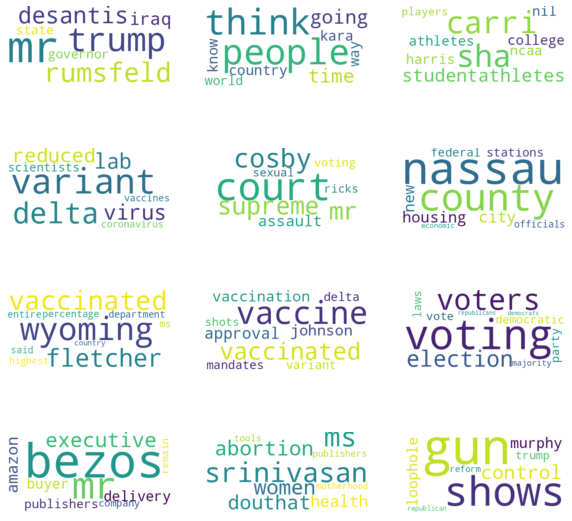

In [30]:
plt.figure(figsize=(10, 10))
for idx, words in cluster_words.items():
    ax = plt.subplot(4, 3, idx + 1)
    words_string = (" ").join(words)
    wordcloud = WordCloud(background_color="white").generate(words_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Evaluation

Since this is clustering (unsupervised) without any ground truth labels, we'll evaluate the model with the silhouette score which gives a range of [-1, 1].  

Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [31]:
from sklearn.metrics import silhouette_score

labels = text_clustering['clustering'].labels_
X = text_clustering.transform(df_articles['article_text_processed'])
silhouette_score(X, labels)

0.821131478640238

The Davies-Bouldin Index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.  

Zero is the lowest possible score, so values closer to zero indicate a better partition.

In [32]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X, labels)

0.17497638926418604

The Calinski-Harabasz index can also be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

In [33]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(X, labels)

926.6836145273867

### Sentiment Analysis

Now we will perform some sentiment analysis on the opinion articles using spaCyTextBlob.

In [34]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

**Polarity** is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.  
negative vs. positive    (-1.0 => +1.0)  

**Subjectivity** is also a float which lies in the range of [0,1]. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information.  
objective vs. subjective (+0.0 => +1.0)

In [35]:
# Drop rows where author is empty
df_articles_sentiment = df_articles.copy()
df_articles_sentiment = df_articles_sentiment[~df_articles_sentiment['author'].eq('')]

In [36]:
for idx, row in df_articles_sentiment.iterrows():
    doc = nlp(row['article_text'])
    df_articles_sentiment.at[idx,'polarity'] = doc._.polarity
    df_articles_sentiment.at[idx,'subjectivity'] = doc._.subjectivity

We can, for example, look at some opinion pieces where the sentiment is more negative:

In [37]:
df_articles_sentiment[df_articles_sentiment['polarity'] < 0.0].sample(3)

,url,title,author,article_text,article_text_processed,cluster_assignment,polarity,subjectivity
93,https://www.nytimes.com/2021/06/25/opinion/cor...,Where Did the Coronavirus Come From? What We A...,Zeynep Tufekci,They have refused to share direct records from...,they refused share direct records lab dr shi ...,3,-0.017914,0.443460
95,https://www.nytimes.com/2021/06/25/opinion/tru...,America Is Getting Meaner,Timothy Egan,I went to see my doctor the other day for a Co...,i went see doctor day coviddelayed physical i...,1,-0.031485,0.587406
94,https://www.nytimes.com/2021/06/25/opinion/imr...,Opinion Q. and A.: Imran Khan Urges a New U.S....,"Yara Bayoumy,Jyoti Thottam",So there was this mistrust between the two cou...,so mistrust two countries and people pakistan...,1,-0.037605,0.329715


In [38]:
df_articles_sentiment['author'].value_counts().head(8)

Paul Krugman             4
The Editorial Board      4
Michelle Goldberg        3
Michelle Cottle          3
The Ezra Klein Show      3
Ross Douthat             2
David Brooks             2
Spencer Bokat-Lindell    2
Name: author, dtype: int64

We will randomly pick an author from above list

In [39]:
df_articles_sentiment[df_articles_sentiment['author'] == 'Michelle Goldberg']

,url,title,author,article_text,article_text_processed,cluster_assignment,polarity,subjectivity
10,https://www.nytimes.com/2021/07/02/opinion/vac...,"Finally, Experts Break the Silence on J.&J. Bo...",Michelle Goldberg,The evidentiary void around J.&J. seemed to gr...,the evidentiary void around j j seemed grow ...,7,0.046883,0.438741
66,https://www.nytimes.com/2021/06/28/opinion/cri...,The Maddening Critical Race Theory Debate,Michelle Goldberg,"Parents protesting critical race theory, he wr...",parents protesting critical race theory wrote...,1,0.080323,0.454070
97,https://www.nytimes.com/2021/06/24/opinion/ind...,How Did a Socialist Triumph in Buffalo?,Michelle Goldberg,That danger is real. Polls reveal that both Bl...,that danger real polls reveal black white vot...,1,0.088406,0.428028


In [41]:
polarity_regressor = Pipeline([('vect', TfidfVectorizer(stop_words='english', ngram_range=(1,3))),
                     ('reg', LinearRegression())])

articles_by_goldberg = df_articles_sentiment[df_articles_sentiment['author'] == 'Michelle Goldberg']
X = articles_by_goldberg.article_text_processed
y = articles_by_goldberg.polarity

# This of course gives the right predictions
polarity_regressor.fit(X, y)
polarity_regressor.predict(X)

array([0.04688269, 0.08032254, 0.0884058 ])

Using the unprocessed article text yields similar results:

In [42]:
polarity_regressor.predict(articles_by_goldberg.article_text)

array([0.04745199, 0.07993006, 0.0879418 ])

### Get more articles from Goldberg

We will get more articles by Goldberg using the NYT Article Search API.

In [43]:
goldberg_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Michelle+Goldberg&api-key={}'.format(access_token)
json = requests.get(goldberg_url).json()
goldberg_articles = pd.DataFrame(json.get('response').get('docs'))

In [44]:
goldberg_articles = goldberg_articles[['web_url', 'byline']] 

for index, row in goldberg_articles.iterrows():
    article = Article(row['web_url'])
    article.download()
    article.parse()
    goldberg_articles.at[index,'article_text'] = article.text
    
goldberg_articles

,web_url,byline,article_text
0,https://www.nytimes.com/2021/07/02/opinion/vac...,"{'original': 'By Michelle Goldberg', 'person':...",The evidentiary void around J.&J. seemed to gr...
1,https://www.nytimes.com/2021/06/28/opinion/cri...,"{'original': 'By Michelle Goldberg', 'person':...","Parents protesting critical race theory, he wr..."
2,https://www.nytimes.com/2021/06/24/opinion/ind...,"{'original': 'By Michelle Goldberg', 'person':...",That danger is real. Polls reveal that both Bl...
3,https://www.nytimes.com/2021/06/21/opinion/nyc...,"{'original': 'By Michelle Goldberg', 'person':...",Last week I wrote about why I thought Eric Ada...
4,https://www.nytimes.com/2021/06/18/opinion/nyc...,"{'original': 'By Michelle Goldberg', 'person':...",So I can hardly believe I’m going to put Adams...
5,https://www.nytimes.com/2021/06/14/opinion/sam...,"{'original': 'By Michelle Goldberg', 'person':...","President Biden, however, is still a believer...."
6,https://www.nytimes.com/2021/06/07/opinion/acl...,"{'original': 'By Michelle Goldberg', 'person':...",I have a foggy childhood memory of being home ...
7,https://www.nytimes.com/2021/06/04/opinion/sin...,"{'original': 'By Michelle Goldberg', 'person':...",We are in the eye of the storm of American dem...
8,https://www.nytimes.com/2021/05/24/opinion/isr...,"{'original': 'By Michelle Goldberg', 'person':...",Violence between Jews and Muslims in the Middl...
9,https://www.nytimes.com/2021/05/17/opinion/us-...,"{'original': 'By Michelle Goldberg', 'person':...",But the explosion of fighting in Israel and Pa...


In [45]:
for idx, row in goldberg_articles.iterrows():
    doc = nlp(row['article_text'])
    goldberg_articles.at[idx,'polarity'] = doc._.polarity
    goldberg_articles.at[idx,'subjectivity'] = doc._.subjectivity

In [46]:
polarity_regressor = Pipeline([('vect', TfidfVectorizer(stop_words='english', ngram_range=(1,3))),
                     ('reg', LinearRegression())])

X = goldberg_articles.article_text
y = goldberg_articles.polarity

# This again gives the right predictions
polarity_regressor.fit(X, y)
goldberg_articles['pred_polarity'] = polarity_regressor.predict(X)

In [47]:
goldberg_articles

,web_url,byline,article_text,polarity,subjectivity,pred_polarity
0,https://www.nytimes.com/2021/07/02/opinion/vac...,"{'original': 'By Michelle Goldberg', 'person':...",The evidentiary void around J.&J. seemed to gr...,0.046883,0.438741,0.046883
1,https://www.nytimes.com/2021/06/28/opinion/cri...,"{'original': 'By Michelle Goldberg', 'person':...","Parents protesting critical race theory, he wr...",0.080323,0.454070,0.080323
2,https://www.nytimes.com/2021/06/24/opinion/ind...,"{'original': 'By Michelle Goldberg', 'person':...",That danger is real. Polls reveal that both Bl...,0.088406,0.428028,0.088406
3,https://www.nytimes.com/2021/06/21/opinion/nyc...,"{'original': 'By Michelle Goldberg', 'person':...",Last week I wrote about why I thought Eric Ada...,0.090093,0.522319,0.090093
4,https://www.nytimes.com/2021/06/18/opinion/nyc...,"{'original': 'By Michelle Goldberg', 'person':...",So I can hardly believe I’m going to put Adams...,-0.056994,0.539650,-0.056994
5,https://www.nytimes.com/2021/06/14/opinion/sam...,"{'original': 'By Michelle Goldberg', 'person':...","President Biden, however, is still a believer....",0.186382,0.418772,0.186382
6,https://www.nytimes.com/2021/06/07/opinion/acl...,"{'original': 'By Michelle Goldberg', 'person':...",I have a foggy childhood memory of being home ...,-0.002183,0.453241,-0.002183
7,https://www.nytimes.com/2021/06/04/opinion/sin...,"{'original': 'By Michelle Goldberg', 'person':...",We are in the eye of the storm of American dem...,0.114286,0.431190,0.114286
8,https://www.nytimes.com/2021/05/24/opinion/isr...,"{'original': 'By Michelle Goldberg', 'person':...",Violence between Jews and Muslims in the Middl...,0.035985,0.264548,0.035985
9,https://www.nytimes.com/2021/05/17/opinion/us-...,"{'original': 'By Michelle Goldberg', 'person':...",But the explosion of fighting in Israel and Pa...,0.153759,0.411216,0.153759


We're now going to use the model to predict Goldberg's sentiments on the other articles.

In [48]:
df_articles_sentiment['pred_polarity_by_goldberg'] = polarity_regressor.predict(df_articles_sentiment['article_text'])

In [51]:
df_articles_sentiment = df_articles_sentiment.drop(['subjectivity', 'article_text_processed'], axis=1)

In [53]:
df_articles_sentiment.sample(5)

,url,title,author,article_text,cluster_assignment,polarity,pred_polarity_by_goldberg
64,https://www.nytimes.com/2021/06/29/opinion/bla...,Black Valedictorians and the Toxic Trope of Bl...,Samuel Getachew,"In his graduation speech last month, Mr. Muham...",0,0.069060,0.074389
43,https://www.nytimes.com/2021/06/30/opinion/cov...,Prioritizing People to Build Back the Economy,"Rashida Tlaib,Eduardo Suplicy",Similar gains can be achieved in the United St...,5,0.132132,0.082133
62,https://www.nytimes.com/2021/06/29/opinion/kam...,Dear Kamala Harris: It’s a Trap!,Christina Greer,Ms. Harris is a complicated figure. She is not...,1,0.127675,0.084821
16,https://www.nytimes.com/2021/07/02/opinion/stu...,Make Americans’ Crushing Debt Disappear,"Astra Taylor,Ezekiel Kweku,Daniel Immerwahr,Jo...",Formerly enslaved people called the phase that...,1,0.132167,0.085555
95,https://www.nytimes.com/2021/06/25/opinion/tru...,America Is Getting Meaner,Timothy Egan,I went to see my doctor the other day for a Co...,1,-0.031485,0.079636


Thank you for listening :)